In [78]:
import numpy as np
import pandas as pd
import glob
import os

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, make_scorer
from sklearn.base import clone
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

#import warnings
#warnings.filterwarnings("ignore")

my_random_state = 2022

In [125]:
feature_path = "/Users/sunshangwen/Dropbox (Personal)/Mac/Desktop/Git Uploads/MTH-9899-Data-Science-II-Project/features_fillna_id.csv"
target_path = "/Users/sunshangwen/Dropbox (Personal)/Mac/Desktop/Git Uploads/MTH-9899-Data-Science-II-Project/merged_data_fillna_timeid.csv"

features = pd.read_csv(feature_path, sep = ",")
target = pd.read_csv(target_path, sep = ",", usecols = ["Date", "Time", "Id", "estVol winsorized", "ResidualNoWinsorCumReturn winsorized"])

features = features.drop(["Unnamed: 0"], axis = 1)
target = target[target["Time"] == "17:30:00.000"]

merged = features.merge(target ,on =['Date','Id']).drop_duplicates()
merged = merged.sort_values(['Id','Date'],ascending = [True, True])
merged["resisual_forwarded"] = merged.groupby(['Id'])["ResidualNoWinsorCumReturn winsorized"].shift(-1)
merged = merged.dropna(how = 'any')

In [126]:
train = merged[merged["Date"] < 20170101]
#validation = merged[(merged["Date"] >= 20160101) & (merged["Date"] < 20170101)]
test = merged[merged["Date"] >= 20170101]
train = train.drop(["Id", "Date", "Time", "ResidualNoWinsorCumReturn winsorized"], axis = 1)
test = test.drop(["Id", "Date", "Time", "ResidualNoWinsorCumReturn winsorized"], axis = 1)

In [128]:
X_train = train.iloc[: , :-1]
y_train = train["resisual_forwarded"]
X_test = test.iloc[: , :-1]
y_test = test["resisual_forwarded"]

In [ ]:
# feature hotmap
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = merged.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)

# do the same scaling to test set
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

In [119]:
def weighted_r2_scorer(model, X, y):

    r2_weight = 1 / np.array(X["estVol winsorized"])
    r2_weight = r2_weight / np.sum(r2_weight)
    
    y_pred = model.predict(X)
        
    return r2_score(y, y_pred, sample_weight = r2_weight)

In [120]:
def self_cross_validation(model, X, y, n_splits = 5, how = "rolling"):

    if how == "walk_forwarding":
        tscv = TimeSeriesSplit(n_splits = n_splits)
        splits = tscv.split(X)
    elif how == "rolling":
        tscv = TimeSeriesSplitImproved(n_splits = n_splits)
        splits = tscv.split(X, fixed_length = True)
    else:
        return None
        
    results = {"test_score": [], "train_score": [], "params": []}
    
    for train_index, val_index in splits:
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        results["params"].append(model.coef_)
        results["test_score"].append(weighted_r2_scorer(model, X_val, y_val))
        results["train_score"].append(weighted_r2_scorer(model, X_train, y_train))

    return results

In [121]:
# create a subclass of TimeSeriesSplit
class TimeSeriesSplitImproved(TimeSeriesSplit):
    """Time Series cross-validator
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide `.
    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    Examples
    --------
    >>> from sklearn.model_selection import TimeSeriesSplit
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4])
    >>> tscv = TimeSeriesSplit(n_splits=3)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(n_splits=3)
    >>> for train_index, test_index in tscv.split(X):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [1] TEST: [2]
    TRAIN: [2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True,
    ...     train_splits=2):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [1 2] TEST: [3]
 
    Notes
    -----
    When ``fixed_length`` is ``False``, the training set has size
    ``i * train_splits * n_samples // (n_splits + 1) + n_samples %
    (n_splits + 1)`` in the ``i``th split, with a test set of size
    ``n_samples//(n_splits + 1) * test_splits``, where ``n_samples``
    is the number of samples. If fixed_length is True, replace ``i``
    in the above formulation with 1, and ignore ``n_samples %
    (n_splits + 1)`` except for the first training set. The number
    of test sets is ``n_splits + 2 - train_splits - test_splits``.
    """
 
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like, with shape (n_samples,), optional
            Always ignored, exists for compatibility.
        fixed_length : bool, hether training sets should always have
            common length
        train_splits : positive int, for the minimum number of
            splits to include in training sets
        test_splits : positive int, for the number of splits to
            include in the test set
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if not (((n_folds - train_splits - test_splits) > 0) and (test_splits > 0)):
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)), test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start], indices[test_start: test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start], indices[test_start:test_start + test_size])

In [122]:
def regmodel_hyperparameter_tuning(alphas_to_try, X, y, n_splits = 5, how_cv = "walk_forwarding", scoring = "weighted_r2", 
                                   model_name = 'Ridge', X_test = None, y_test = None, draw_plot = False, filename = None):
    
    # tuning the hyper-parameter by grid searching
    # optimising on one basis but then comparing performance on another
    # scoring method: weighted R-squared
    
    validation_scores = []
    train_scores = []
    results_list = []
    
    if X_test is not None:
        test_scores = []
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        if model_name == 'Lasso':
            regmodel = Lasso(alpha = curr_alpha, tol = 1e-3, max_iter = 10000)
            
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
            
        elif model_name == 'SimpleLR':
            regmodel = LinearRegression()
            
        else:
            return None        

        results = self_cross_validation(regmodel, X, y, n_splits = n_splits, how = how_cv)
        #tscv = TimeSeriesSplit(n_splits = n_splits)
        #results = cross_validate(regmodel, X, y, scoring = "r2", cv=tscv, return_train_score = True)
        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)
        print(results)

        if X_test is not None:
            regmodel = regmodel.fit(X, y)
            y_pred = regmodel.predict(X_test)
            r2_weight = 1 / X_test["estVol winsorized"]
            #test_scores.append(weighted_r2_scorer(regmodel, X_test, y_test)) #######################
            test_scores.append(r2_score(y_test, y_pred, sample_weight = r2_weight))

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(validation_scores, train_scores, alphas_to_try, chosen_alpha, 
                            model_name, scoring, test_scores, filename)
        
    print("Chosen alpha: %.5f" % chosen_alpha)
    print("Validation score: %.5f" % max_validation_score)
    print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha




def regmodel_param_plot(validation_score, train_score, alphas_to_try, chosen_alpha, scoring,
                        model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, label = 'training_data')
    plt.axvline(x = chosen_alpha, linestyle = '--')
    
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, label = 'test_data')
        
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularization')
    plt.legend()
    
    if filename is not None:
        plt.savefig(str(filename) + ".png")
        
    plt.show()
    

{'test_score': [-4.712520911165363e-05, 4.473050825637426e-05, -8.514660565639431e-05, -3.2862472754580097e-05, 0.00010582962280225594], 'train_score': [4.2142071253303826e-05, 7.651313878465071e-05, 7.045439352504346e-05, 5.3600745615001166e-05, 3.7548905991613424e-05], 'params': [array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.13365308e-09, -0.00000000e+00,
       -0.00000000e+00, -5.36003909e-10, -1.14251885e-09, -6.52008064e-09,
        7.70117441e-09,  0.00000000e+00]), array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,

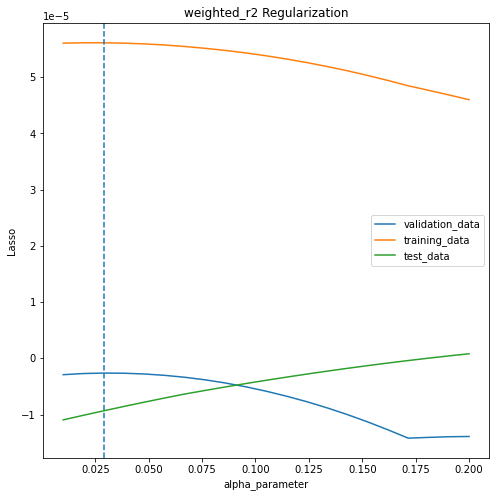

Chosen alpha: 0.02900
Validation score: -0.00000
Test score at chosen alpha: -0.00001


(0.028999999999999998, -2.6301719394661305e-06, -9.335706602886518e-06)

In [130]:
# wide search
# lasso model
lasso_alphas = np.linspace(0.01, 0.2, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Lasso', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

{'test_score': [-4.706231985829312e-05, 4.5132683114568195e-05, -8.698284631480924e-05, -3.419133835769195e-05, 0.00010718578842316973], 'train_score': [4.1625848042237124e-05, 7.643284069880352e-05, 7.049548007298512e-05, 5.3556524940989725e-05, 3.751188257294924e-05], 'params': [array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.14580256e-09, -0.00000000e+00,
       -0.00000000e+00, -5.41956848e-10, -1.13751609e-09, -6.72848805e-09,
        8.12955927e-09,  0.00000000e+00]), array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,


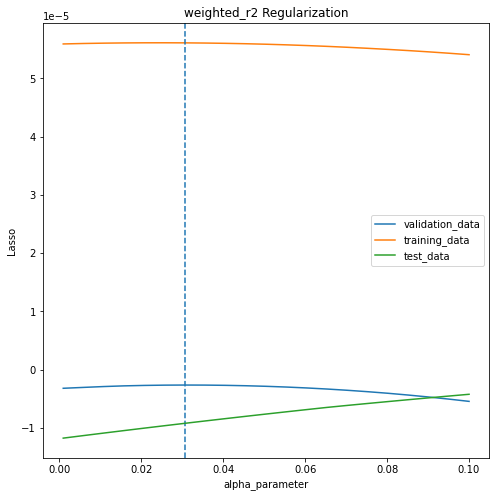

Chosen alpha: 0.03070
Validation score: -0.00000
Test score at chosen alpha: -0.00001


(0.030700000000000005, -2.627272648458856e-06, -9.195182615995279e-06)

In [131]:
# wide search
# lasso model
lasso_alphas = np.linspace(0.001, 0.1, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Lasso', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

{'test_score': [-4.752936721397205e-05, 4.4384741695435714e-05, -8.320368758374386e-05, -3.140519688105137e-05, 0.0001042417042133037], 'train_score': [4.260822509649653e-05, 7.653049408717916e-05, 7.03449587974303e-05, 5.358923613696387e-05, 3.7521366904602615e-05], 'params': [array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.12015184e-09, -0.00000000e+00,
       -0.00000000e+00, -5.29011778e-10, -1.14915024e-09, -6.28777935e-09,
        7.22518028e-09,  0.00000000e+00]), array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
   

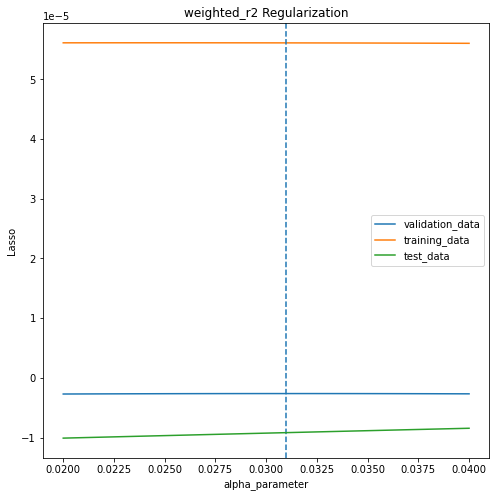

Chosen alpha: 0.03100
Validation score: -0.00000
Test score at chosen alpha: -0.00001


(0.031, -2.6271151523982183e-06, -9.170448681983245e-06)

In [132]:
# wide search
# lasso model
lasso_alphas = np.linspace(0.02, 0.04, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Lasso', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

In [137]:
regmodel = Lasso(alpha = 0.031)
regmodel.fit(X_train, y_train)
y_pred = regmodel.predict(X_test)
r2_weight = 1 / X_test["estVol winsorized"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))

-9.16329511313485e-06


{'test_score': [0.0019903614853516993, 0.0020023938528346275, 0.0018621506211503602, 0.0019684722889312667, 0.0008137607983066397], 'train_score': [0.0019279801847711386, 0.0024402386540215426, 0.0023113677662220944, 0.002224937000006366, 0.0021623065218293602], 'params': [array([ 4.39628376e-03,  1.12719752e-03,  7.23181890e-02,  2.30569810e-02,
        1.35021217e+07, -8.74857765e+06, -1.47797377e+06, -3.27557028e+06,
       -8.74857766e+06, -1.47797374e+06, -3.27557024e+06, -1.23744463e+07,
        2.31665569e+07,  1.00472722e+07, -2.08393827e+07,  2.31665569e+07,
        1.00472722e+07, -2.08393828e+07,  1.05831786e-09, -5.06703139e-04,
       -4.68166551e-04, -1.81252499e-09,  7.18242110e-09, -1.54410349e-08,
        8.50169527e-09, -1.01899098e-04]), array([ 1.20484829e-02, -4.73301037e-04,  9.62559766e-02,  3.12588410e-03,
       -1.10433596e+06, -5.33313428e+06,  5.58591073e+06,  8.51559468e+05,
       -5.33313428e+06,  5.58591075e+06,  8.51559502e+05, -3.94119986e+06,
        

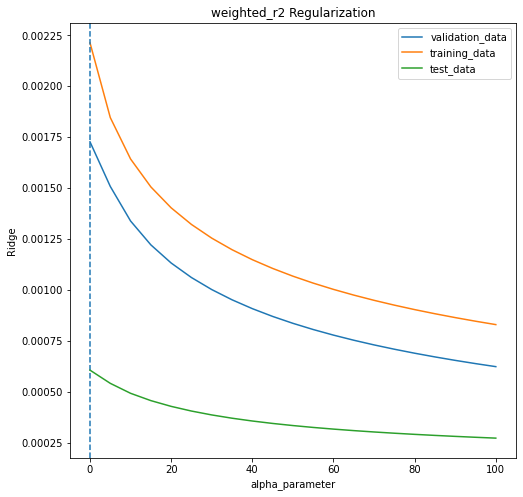

Chosen alpha: 0.00000
Validation score: 0.00173
Test score at chosen alpha: 0.00061


(0.0, 0.0017274278093149186, 0.0006070725772527874)

In [135]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 100, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

{'test_score': [0.0019903614853516993, 0.0020023938528346275, 0.0018621506211503602, 0.0019684722889312667, 0.0008137607983066397], 'train_score': [0.0019279801847711386, 0.0024402386540215426, 0.0023113677662220944, 0.002224937000006366, 0.0021623065218293602], 'params': [array([ 4.39628376e-03,  1.12719752e-03,  7.23181890e-02,  2.30569810e-02,
        1.35021217e+07, -8.74857765e+06, -1.47797377e+06, -3.27557028e+06,
       -8.74857766e+06, -1.47797374e+06, -3.27557024e+06, -1.23744463e+07,
        2.31665569e+07,  1.00472722e+07, -2.08393827e+07,  2.31665569e+07,
        1.00472722e+07, -2.08393828e+07,  1.05831786e-09, -5.06703139e-04,
       -4.68166551e-04, -1.81252499e-09,  7.18242110e-09, -1.54410349e-08,
        8.50169527e-09, -1.01899098e-04]), array([ 1.20484829e-02, -4.73301037e-04,  9.62559766e-02,  3.12588410e-03,
       -1.10433596e+06, -5.33313428e+06,  5.58591073e+06,  8.51559468e+05,
       -5.33313428e+06,  5.58591075e+06,  8.51559502e+05, -3.94119986e+06,
        

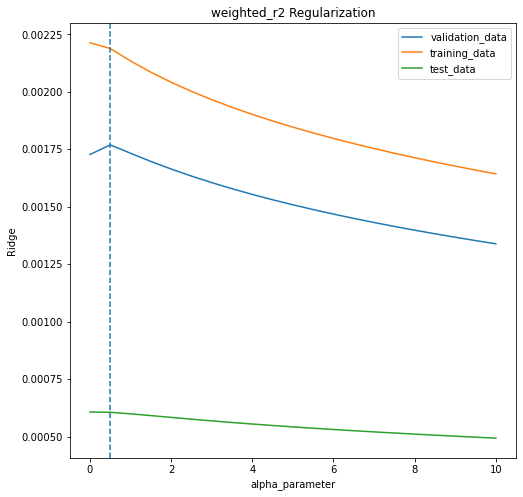

Chosen alpha: 0.50000
Validation score: 0.00177
Test score at chosen alpha: 0.00061


(0.5, 0.0017690263688925566, 0.0006057172632246699)

In [136]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 10, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

{'test_score': [0.0019903614853516993, 0.0020023938528346275, 0.0018621506211503602, 0.0019684722889312667, 0.0008137607983066397], 'train_score': [0.0019279801847711386, 0.0024402386540215426, 0.0023113677662220944, 0.002224937000006366, 0.0021623065218293602], 'params': [array([ 4.39628376e-03,  1.12719752e-03,  7.23181890e-02,  2.30569810e-02,
        1.35021217e+07, -8.74857765e+06, -1.47797377e+06, -3.27557028e+06,
       -8.74857766e+06, -1.47797374e+06, -3.27557024e+06, -1.23744463e+07,
        2.31665569e+07,  1.00472722e+07, -2.08393827e+07,  2.31665569e+07,
        1.00472722e+07, -2.08393828e+07,  1.05831786e-09, -5.06703139e-04,
       -4.68166551e-04, -1.81252499e-09,  7.18242110e-09, -1.54410349e-08,
        8.50169527e-09, -1.01899098e-04]), array([ 1.20484829e-02, -4.73301037e-04,  9.62559766e-02,  3.12588410e-03,
       -1.10433596e+06, -5.33313428e+06,  5.58591073e+06,  8.51559468e+05,
       -5.33313428e+06,  5.58591075e+06,  8.51559502e+05, -3.94119986e+06,
        

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.42807e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.71332e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41714e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.58385e-17): result may not be accurate

{'test_score': [0.002279687124051466, 0.002002460806569406, 0.0018770107588022, 0.001971830698767163, 0.0008143233657269544], 'train_score': [0.0020091542785992678, 0.0024364578964598538, 0.0023146477894319117, 0.002233340780044224, 0.002165946575718003], 'params': [array([ 1.59619736e-03,  4.67146546e-03,  7.76313128e-02,  1.29746149e-02,
       -6.56375641e-03,  1.05102027e-03, -1.81646442e-02, -1.78457445e-02,
       -7.61477669e-03,  1.16008878e-02,  1.12819881e-02,  9.18622847e-03,
       -1.47275690e-03,  8.10665210e-03,  4.03743608e-02,  1.06589854e-02,
        1.07957638e-03, -3.11881324e-02, -1.01854825e-09, -4.99279220e-04,
       -4.67639560e-04, -3.11645377e-10, -1.20753434e-09, -6.96526507e-09,
        7.87296923e-09, -8.66732537e-05]), array([ 1.24128588e-02, -6.10574751e-04,  9.30648046e-02,  4.36455664e-03,
       -5.90600611e-03, -6.26792304e-05, -1.08469515e-02, -1.86911585e-02,
       -5.84332688e-03,  4.94094543e-03,  1.27851524e-02,  2.73160460e-03,
       -3.37556

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.33094e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.81716e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.15699e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


{'test_score': [0.0022740726183213544, 0.002002199141822647, 0.0018789413851497683, 0.0019735164248826376, 0.0008178804607595902], 'train_score': [0.002001427016224744, 0.0024326555135130157, 0.0023131156001859887, 0.0022327452828385663, 0.0021655513485336897], 'params': [array([ 2.34850990e-03,  4.31912386e-03,  7.31865059e-02,  1.48684022e-02,
       -5.88028436e-03,  1.09063330e-03, -1.77467938e-02, -1.56492361e-02,
       -6.97091766e-03,  1.18665095e-02,  9.76895176e-03,  7.94957766e-03,
       -1.62408128e-03,  7.62146397e-03,  3.62423299e-02,  9.57365895e-03,
        3.28113695e-04, -2.82927522e-02, -1.01635281e-09, -4.99646578e-04,
       -4.66496060e-04, -3.05266455e-10, -1.22527920e-09, -6.95771847e-09,
        7.86879886e-09, -7.49283428e-05]), array([ 1.28080479e-02, -8.11434966e-04,  9.01861039e-02,  5.80192580e-03,
       -5.61727727e-03,  1.78730148e-05, -1.07551175e-02, -1.77680529e-02,
       -5.63515028e-03,  5.13784026e-03,  1.21507757e-02,  2.26364810e-03,
       -3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.09653e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.02017e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.72027e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


{'test_score': [0.002265145882294095, 0.0020009160036222884, 0.0018801328519675309, 0.0019747988058717025, 0.0008210403303523517], 'train_score': [0.001990544121349802, 0.00242789327609394, 0.0023110039968778917, 0.002231774545879306, 0.0021649265592558198], 'params': [array([ 2.96296852e-03,  4.05078562e-03,  6.93776666e-02,  1.63913182e-02,
       -5.32580412e-03,  1.08565748e-03, -1.73414854e-02, -1.39068584e-02,
       -6.41146160e-03,  1.20156813e-02,  8.58105425e-03,  6.93829083e-03,
       -1.70211455e-03,  7.14120161e-03,  3.29191328e-02,  8.64040538e-03,
       -2.02910785e-04, -2.59808420e-02, -1.01452366e-09, -4.99926039e-04,
       -4.65478005e-04, -2.99753291e-10, -1.23996348e-09, -6.95082066e-09,
        7.86551810e-09, -6.56286210e-05]), array([ 1.31501208e-02, -9.77988517e-04,  8.75406161e-02,  7.09318293e-03,
       -5.35678646e-03,  8.34861248e-05, -1.06596169e-02, -1.69479479e-02,
       -5.44027258e-03,  5.30283041e-03,  1.15911615e-02,  1.84371395e-03,
       -3.60

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.02744e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


{'test_score': [0.0022425898637880026, 0.0019962013816123836, 0.0018807726292217053, 0.001976358053369709, 0.0008263255548397463], 'train_score': [0.001964740359465922, 0.0024164552957606222, 0.0023054641462347814, 0.0022289174602928563, 0.0021630945447788097], 'params': [array([ 3.89369235e-03,  3.69202817e-03,  6.31624139e-02,  1.86351370e-02,
       -4.47727787e-03,  1.00480418e-03, -1.65862862e-02, -1.13225414e-02,
       -5.48208205e-03,  1.21090083e-02,  6.84526353e-03,  5.37311946e-03,
       -1.74367722e-03,  6.24453760e-03,  2.78864400e-02,  7.11679669e-03,
       -8.71418137e-04, -2.25133205e-02, -1.01160864e-09, -5.00333880e-04,
       -4.63764876e-04, -2.90633283e-10, -1.26256128e-09, -6.93918306e-09,
        7.86108023e-09, -5.19542186e-05]), array([ 1.37034856e-02, -1.22722659e-03,  8.28377265e-02,  9.30968720e-03,
       -4.90366380e-03,  1.80962228e-04, -1.04635968e-02, -1.55523019e-02,
       -5.08462603e-03,  5.55993297e-03,  1.06486381e-02,  1.11902498e-03,
       -3

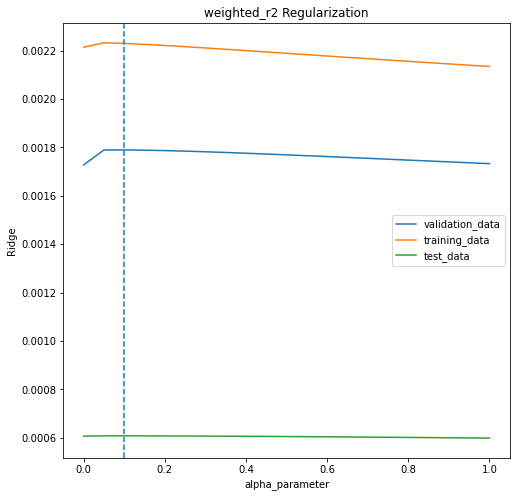

Chosen alpha: 0.10000
Validation score: 0.00179
Test score at chosen alpha: 0.00061


(0.1, 0.0017893220061871995, 0.0006085630614132143)

In [138]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 1.0, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

{'test_score': [0.0019903614853516993, 0.0020023938528346275, 0.0018621506211503602, 0.0019684722889312667, 0.0008137607983066397], 'train_score': [0.0019279801847711386, 0.0024402386540215426, 0.0023113677662220944, 0.002224937000006366, 0.0021623065218293602], 'params': [array([ 4.39628376e-03,  1.12719752e-03,  7.23181890e-02,  2.30569810e-02,
        1.35021217e+07, -8.74857765e+06, -1.47797377e+06, -3.27557028e+06,
       -8.74857766e+06, -1.47797374e+06, -3.27557024e+06, -1.23744463e+07,
        2.31665569e+07,  1.00472722e+07, -2.08393827e+07,  2.31665569e+07,
        1.00472722e+07, -2.08393828e+07,  1.05831786e-09, -5.06703139e-04,
       -4.68166551e-04, -1.81252499e-09,  7.18242110e-09, -1.54410349e-08,
        8.50169527e-09, -1.01899098e-04]), array([ 1.20484829e-02, -4.73301037e-04,  9.62559766e-02,  3.12588410e-03,
       -1.10433596e+06, -5.33313428e+06,  5.58591073e+06,  8.51559468e+05,
       -5.33313428e+06,  5.58591075e+06,  8.51559502e+05, -3.94119986e+06,
        

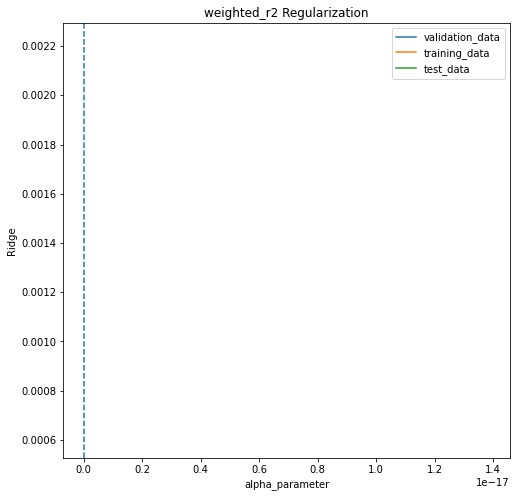

Chosen alpha: 0.00000
Validation score: 0.00173
Test score at chosen alpha: 0.00061


(0, 0.0017274278093149186, 0.0006070725772527874)

In [139]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 1.0, 21)
regmodel_hyperparameter_tuning([0], X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

In [140]:
regmodel = LinearRegression()
regmodel.fit(X_train, y_train)
y_pred = regmodel.predict(X_test)
r2_weight = 1 / X_test["estVol winsorized"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))

0.0006086253483456039


In [142]:
regmodel = Ridge(alpha = 0.03)
regmodel.fit(X_train, y_train)
y_pred = regmodel.predict(X_test)
r2_weight = 1 / X_test["estVol winsorized"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))

0.0006086439815248257


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.55164e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
